In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

from Gmodel import GProblem


# Visualising solutions

The code creates sample solution landscapes similar to those reported by Grim et al. - not included in paper.

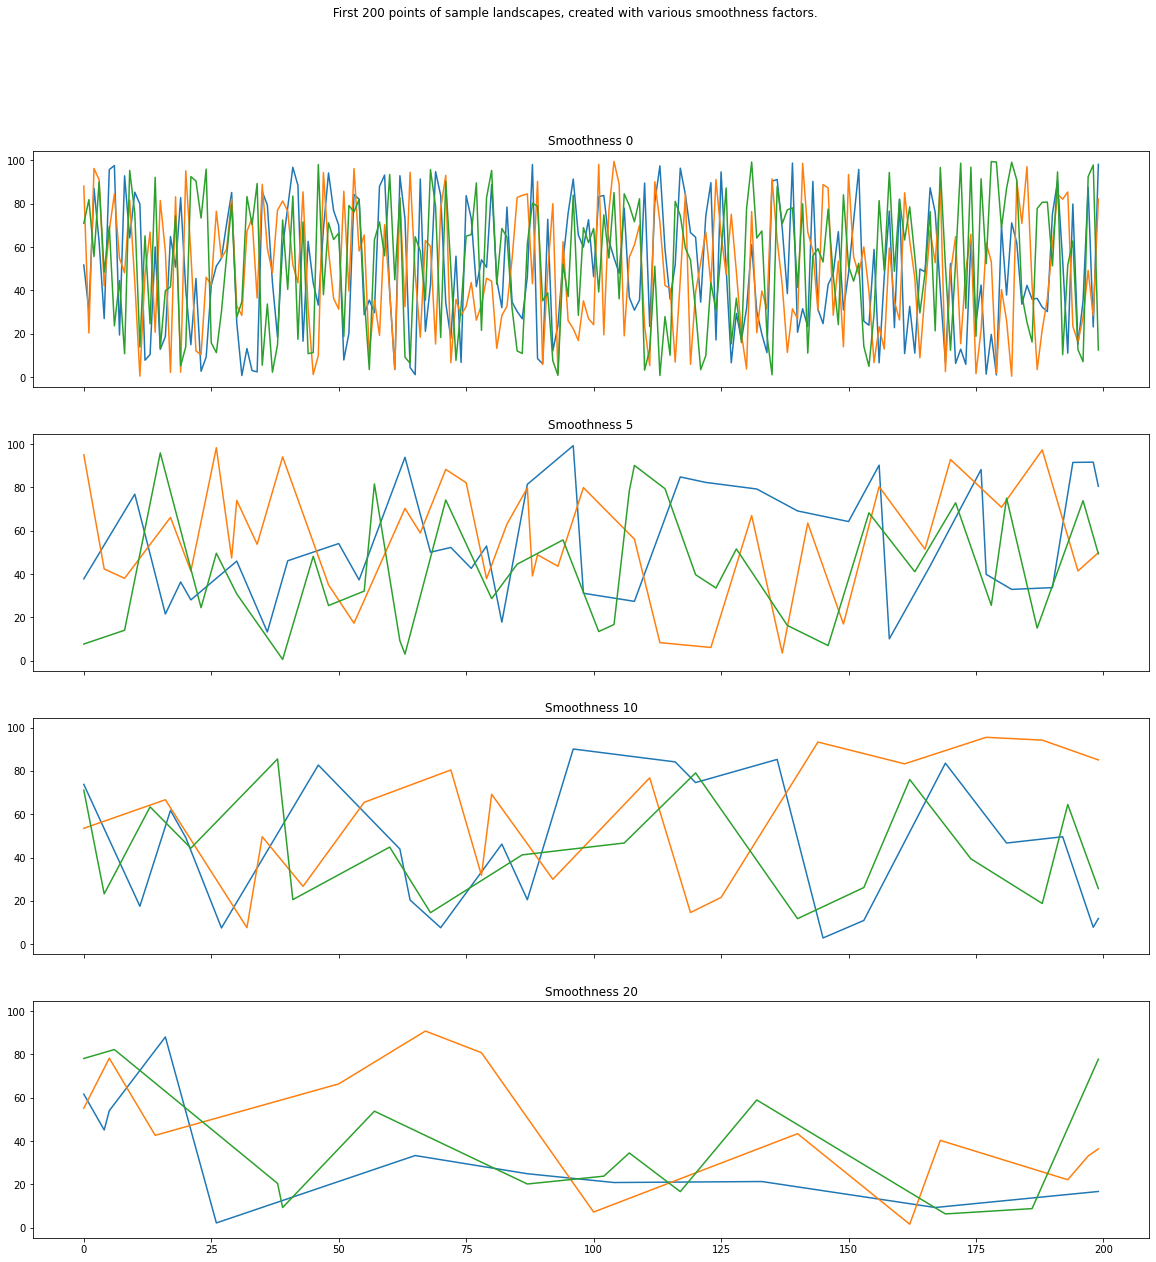

In [4]:
solutions = []
for s in [0, 5, 10, 20]:
        solutions.append(GProblem(2000, 2, 2, 2, s).solution)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle(' First 200 points of sample landscapes, created with various smoothness factors.')

ax[0].plot(range(0,200), solutions[0][:200], label='Smoothness 0')
ax[0].set_title("Smoothness 0")
ax[1].plot(range(0,200), solutions[1][:200], label='Smoothness 5')
ax[1].set_title("Smoothness 5")
ax[2].plot(range(0,200), solutions[2][:200], label='Smoothness 10')
ax[2].set_title("Smoothness 10")
ax[3].plot(range(0,200), solutions[3][:200], label='Smoothness 20')
ax[3].set_title("Smoothness 20")

solutions = []
for s in [0, 5, 10, 20]:
        solutions.append(GProblem(2000, 2, 2, 2, s).solution)

ax[0].plot(range(0,200), solutions[0][:200], label='Smoothness 0')
ax[1].plot(range(0,200), solutions[1][:200], label='Smoothness 5')
ax[2].plot(range(0,200), solutions[2][:200], label='Smoothness 10')
ax[3].plot(range(0,200), solutions[3][:200], label='Smoothness 20')

solutions = []
for s in [0, 5, 10, 20]:
        solutions.append(GProblem(2000, 2, 2, 2, s).solution)

ax[0].plot(range(0,200), solutions[0][:200], label='Smoothness 0')
ax[1].plot(range(0,200), solutions[1][:200], label='Smoothness 5')
ax[2].plot(range(0,200), solutions[2][:200], label='Smoothness 10')
ax[3].plot(range(0,200), solutions[3][:200], label='Smoothness 20')

fig.savefig("Figure1.png")


# Grim et al - replication runs - main

500 replication runs were conducted on GCE, using [pyscript2GCE](https://github.com/LukasWallrich/pyscript2gce-production). See `run_simulation_simple.py` for the code used.

In [ ]:
# Analysis of results

In [5]:
import pickle

with open("Grimmodel_results.pkl",'rb') as f:
    res = pickle.load(f)



In [6]:
def prep_outputs(res):
    if "solution" in res.columns:
        res.rename({"solution": "best_solution"}, inplace=True)
    res = pd.concat([res.drop(["best_solution"], axis = 1), res.best_solution.apply(pd.Series).add_suffix("_solution")], axis = 1)

    def renamer(col, prefix):
        if col.endswith("agent"):
            return col
        else:
            return prefix + col

    res_random = res.agent_descriptives.apply(pd.Series).random.apply(pd.Series).rename(mapper = partial(renamer, prefix = "random_"), axis = "columns")

    res_best = res.agent_descriptives.apply(pd.Series).best.apply(pd.Series).rename(mapper = partial(renamer, prefix = "best_"), axis = "columns")

    res = pd.concat([res.drop(["agent_descriptives"], axis=1), res_best, res_random[res_random.columns[pd.Series(res_random.columns).str.startswith('random_')]]], axis=1)

    res["run_id"] = res.reset_index().index
    res = res.rename(columns={"best_agent": "top_agent"})
    res["gap"] = res["random_solution"] - res["best_solution"]
    return(res)



In [7]:
res = prep_outputs(res)

## Reproducing Figure 2

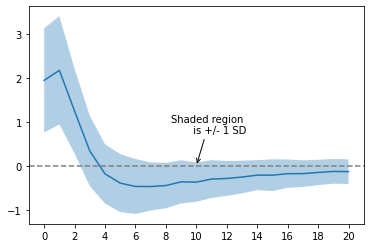

In [8]:
gaps = res[["smoothness", "gap"]].groupby(["smoothness"]).describe().loc[:, (slice(None), ["mean", "std"])]
gaps.columns = gaps.columns.droplevel(0)
gaps.reset_index(inplace=True)

fig, ax = plt.subplots()

tickpos = range(0, 21, 2)

ax.plot(gaps["smoothness"], gaps["mean"])
ax.fill_between(gaps["smoothness"], gaps["mean"] - gaps["std"], gaps["mean"] + gaps["std"], alpha=0.35)
ax.axhline(y=0, color='grey', linestyle='--')
ax.set_xticks(tickpos)

ax.annotate('Shaded region \n is +/- 1 SD',
            xy=(10, .01), xycoords='data',
            xytext=(50, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle = "->"),
            horizontalalignment='right', verticalalignment='bottom')

fig.figure.savefig("Fig2.png")


Out of interest - the following replicates the table from Hong & Page. Key insight: overall performance declines with higher smoothness.

In [15]:
#Pivot so that random and best groups can be easily compared
col_names = res.columns.values.tolist()

def check_var(col_name):
    return not(col_name.find("random_") != -1 or col_name.find("best_") != -1)


id_cols = list(filter(check_var, col_names))

out = pd.melt(res, id_cols)

out = out.join(out.variable.str.split("_", expand = True)).rename(columns={0:"team_type"}).pivot_table(index=id_cols + ["team_type"], columns=[1], values="value").reset_index()

out["NPdiversity"] = out["NPdiversity"] * 100 #Convert to percentages


In [16]:
tbl = out[["team_type", "smoothness", "solution", "NPdiversity"]].groupby(["smoothness", "team_type"]).describe().loc[:, (slice(None), ["mean", "std"])]

tbl = tbl.round(2)

sol = pd.DataFrame(tbl[('solution', 'mean')].astype(str) + " (" +  tbl[('solution', 'std')].astype(str) + ")")
sol.columns = ["Solution"]

div = pd.DataFrame(tbl[('NPdiversity', 'mean')].astype(str) + " (" +  tbl[('NPdiversity', 'std')].astype(str) + ")")
div.columns = ["Diversity"]

sol = sol.join(div)

sol

Solution     Diversity
smoothness team_type                            
0          best        92.4 (1.28)  84.66 (4.15)
           random     94.35 (0.58)  91.54 (2.31)
1          best       89.31 (1.22)  77.04 (4.58)
           random      91.49 (0.8)  91.65 (2.35)
2          best       85.43 (1.26)  76.56 (3.94)
           random     86.68 (1.17)   91.8 (2.45)
3          best        82.4 (1.25)  76.15 (3.04)
           random     82.74 (1.45)   91.84 (2.3)
4          best        80.0 (1.39)  73.41 (3.57)
           random     79.82 (1.54)  91.63 (2.35)
5          best       77.89 (1.65)  70.71 (4.29)
           random      77.5 (1.75)  91.73 (2.21)
6          best       75.81 (1.78)   68.3 (5.26)
           random     75.34 (1.91)  91.71 (2.43)
7          best       74.41 (1.86)   67.1 (5.71)
           random     73.94 (1.96)  91.65 (2.33)
8          best       73.13 (2.03)  66.37 (6.42)
           random     72.69 (2.11)  91.89 (2.33)
9          best       72.06 (2.18)   66.11 (6.3)
           random      71.7 (2.24)  91.63 (2.37)
10         best       71.24 (2.25)  66.73 (6.15)
           random     70.87 (2.31)  91.76 (2.38)
11         best       70.72 (2.58)  66.21 (6.16)
           random     70.42 (2.61)   91.52 (2.3)
12         best       70.15 (2.51)  67.29 (6.22)
           random     69.87 (2.53)   91.8 (2.42)
13         best       69.71 (2.63)  67.57 (5.74)
           random     69.46 (2.68)  91.84 (2.31)
14         best       69.51 (2.64)  67.35 (5.75)
           random     69.31 (2.66)  91.83 (2.18)
15         best       68.95 (2.76)   67.83 (5.2)
           random     68.75 (2.75)  91.72 (2.19)
16         best       68.58 (2.96)  68.15 (5.13)
           random      68.4 (2.98)  91.73 (2.29)
17         best        68.2 (2.95)  68.29 (5.36)
           random     68.03 (2.99)   91.6 (2.45)
18         best       67.87 (3.14)  68.58 (5.71)
           random     67.72 (3.14)  91.67 (2.39)
19         best       67.73 (3.23)  68.66 (5.29)
           random      67.6 (3.23)   91.8 (2.28)
20         best       67.82 (3.39)  69.03 (5.38)
           random      67.7 (3.41)  91.79 (2.25)

# Replication of tournament results

The comparisons between best and random groups under tournament setting was only tested with 100 runs but with l ranging up to 30. This already increased computational expense >5x compared to the range considered in the original paper.

In [17]:
import os
import pickle

#directory = os.fsencode(".")

res = []

for file in os.listdir("."):
     filename = os.fsdecode(file)
     if filename.startswith("GrimSweepTournament"): #Multiple files from use of spot VMs
         with open(filename,'rb') as f:
            res.append(pickle.load(f))
         continue
     else:
         continue

res = pd.concat(res)


In [18]:
## Beware: this cell is very slow (~90 seconds)

def renamer(col, prefix):
    if col.endswith("agent"):
        return col
    else:
        return prefix + col

res = pd.concat([res.drop(["best_solution"], axis = 1), res.best_solution.apply(pd.Series).add_suffix("_solution")], axis = 1)
res_random = res.agent_descriptives.apply(pd.Series).random.apply(pd.Series).rename(mapper = partial(renamer, prefix = "random_"), axis = "columns")
res_best = res.agent_descriptives.apply(pd.Series).best.apply(pd.Series).rename(mapper = partial(renamer, prefix = "best_"), axis = "columns")
res = pd.concat([res.drop(["agent_descriptives"], axis=1), res_best, res_random[res_random.columns[pd.Series(res_random.columns).str.startswith('random_')]]], axis=1)
res["run_id"] = res.reset_index().index
res.rename(columns={"best_agent": "top_agent"}, inplace=True)
res["tournament_gap"] = res["tournament_random_solution"] - res["tournament_best_solution"]
res["relay_gap"] = res["relay_random_solution"] - res["relay_best_solution"]

res

,smoothness,l,Run,n,k,N_agents,strategy,relay_random_solution,relay_best_solution,tournament_best_solution,...,worst_agent,average_agent,top_agent,best_team_average,best_NPdiversity,random_team_average,random_NPdiversity,run_id,tournament_gap,relay_gap
0,0,4,2000,2000,3,10,both,87.130439,87.067030,89.639316,...,83.548408,84.692727,85.260399,85.029587,0.777778,84.766353,0.777778,0,0.013697,0.063409
7555,14,4,2000,2000,3,10,both,65.320451,65.268111,65.643081,...,64.735976,65.000835,65.268111,65.206316,0.792593,65.026979,0.740741,1,0.001493,0.052340
7556,14,4,2000,2000,3,10,both,67.648918,67.805270,68.109112,...,67.206296,67.567861,67.805270,67.756968,0.777778,67.461659,0.800000,2,0.001168,-0.156351
7557,14,4,2000,2000,3,10,both,66.407470,66.390484,66.609500,...,65.713575,66.093673,66.390484,66.322567,0.792593,66.139409,0.777778,3,-0.002121,0.016986
7558,14,4,2000,2000,3,10,both,60.313102,60.405521,60.630021,...,60.022648,60.218722,60.404031,60.361134,0.792593,60.241078,0.800000,4,0.001452,-0.092419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,7,4,2000,2000,3,10,both,65.843420,65.869825,66.684937,...,64.796483,65.324502,65.869825,65.722916,0.792593,65.406509,0.807407,56695,-0.044066,-0.026404
7555,7,4,2000,2000,3,10,both,67.248153,67.591505,68.427102,...,66.686416,67.090502,67.591505,67.416349,0.792593,67.270774,0.785185,56696,-0.005341,-0.343352
7554,7,4,2000,2000,3,10,both,66.898764,67.423539,68.114326,...,66.376452,66.902519,67.423539,67.266774,0.792593,66.818405,0.785185,56697,0.006684,-0.524775
7530,6,30,2000,2000,3,10,both,85.029784,80.925072,84.303744,...,65.035202,74.063727,80.208502,80.047676,0.800000,76.348017,0.933333,56698,5.552481,4.104712


In [21]:
comps = res.groupby(["l", "smoothness"]).apply(lambda s: pd.Series({
    "tournament_random_advantage": s["tournament_gap"].mean(),
    "relay_random_advantage": s["relay_gap"].mean(),
    "tournament_advantage_random": (s["tournament_random_solution"] - s["relay_random_solution"]).mean(),
    "tournament_advantage_best": (s["tournament_best_solution"] - s["relay_best_solution"]).mean()
}))

In [22]:
win_comps = pd.DataFrame([
    {"Strategy":"Relay", "Win rate (%)": (comps["relay_random_advantage"]>0).mean().round(3) * 100,
    "Mean advantage": comps["relay_random_advantage"].mean().round(2), 
    "random_mean": comps["relay_random_advantage"][comps["relay_random_advantage"]>0].mean().round(2), 
    "random_max": comps["relay_random_advantage"][comps["relay_random_advantage"]>0].max().round(2), 
    "best_mean": abs(comps["relay_random_advantage"][comps["relay_random_advantage"]<0].mean().round(2)), 
    "best_max": abs(comps["relay_random_advantage"][comps["relay_random_advantage"]<0].min().round(2))},
    {"Strategy":"Tournament", "Win rate (%)": (comps["tournament_random_advantage"]>0).mean().round(3) * 100,
    "Mean advantage": comps["tournament_random_advantage"].mean().round(2), 
    "random_mean": comps["tournament_random_advantage"][comps["tournament_random_advantage"]>0].mean().round(2), 
    "random_max": comps["tournament_random_advantage"][comps["tournament_random_advantage"]>0].max().round(2), 
    "best_mean": abs(comps["tournament_random_advantage"][comps["tournament_random_advantage"]<0].mean().round(2)), 
    "best_max": abs(comps["tournament_random_advantage"][comps["tournament_random_advantage"]<0].min().round(2))}])

   
win_comps.to_latex("win_comparisons.tex")

win_comps

,Strategy,Win rate (%),Mean advantage,random_mean,random_max,best_mean,best_max
0,Relay,25.9,0.14,1.50,3.32,0.34,0.69
1,Tournament,60.0,0.54,0.93,2.58,0.06,0.21


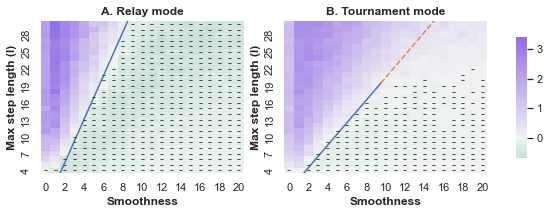

In [23]:
import seaborn as sns; sns.set_theme()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2.8))
cbar_ax = fig.add_axes([.95, .2, .02, .6])

relay = comps[["relay_random_advantage"]].reset_index().pivot("l", "smoothness", "relay_random_advantage")
relay_neg = (relay >= 0).replace([True, False], ["", "-"])
cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
sns.heatmap(relay, cmap = cmap, center = 0, annot = relay_neg, fmt = '', ax = ax1, vmin = -.7, vmax = 3.4, cbar_ax=cbar_ax)
ax1.invert_yaxis()
ax1.plot([2,9], [0,27])
ax1.set_title("A. Relay mode", fontweight='bold')
ax1.set_ylabel("Max step length (l)", fontweight='bold')
ax1.set_xlabel("Smoothness", fontweight='bold')

tourn = comps[["tournament_random_advantage"]].reset_index().pivot("l", "smoothness", "tournament_random_advantage")
tourn_neg = (tourn >= 0).replace([True, False], ["", "-"])
sns.heatmap(tourn, cmap = cmap, center = 0, annot = tourn_neg, fmt = '', ax = ax2, vmin = -.7, vmax = 3.4, cbar_ax=cbar_ax)
ax2.invert_yaxis()
ax2.plot([2,10], [0,16])
ax2.plot([10,16], [16,28], linestyle='dashed')
ax2.set_title("B. Tournament mode", fontweight='bold')
ax2.set_ylabel("Max step length (l)", fontweight='bold')
ax2.set_xlabel("Smoothness", fontweight='bold')

fig.figure.savefig("Fig69.png")
fig.figure.savefig("../manuscript/Fig69.png", bbox_inches='tight')



In [ ]:
# Tournaments vs relays 

In [24]:

pd.DataFrame([
    {"Group":"Random", "Tournament wins (%)": (comps["tournament_advantage_random"]>0).mean().round(3) * 100,
    "Mean advantage": comps["tournament_advantage_random"].mean().round(2)},
     
    {"Group":"Best", "Tournament wins (%)": (comps["tournament_advantage_best"]>0).mean().round(3) * 100,
    "Mean advantage": comps["tournament_advantage_best"].mean().round(2)}])

,Group,Tournament wins (%),Mean advantage
0,Random,100.0,2.68
1,Best,100.0,2.28
